In [2]:
!pip install numpy matplotlib
!pip install fenics
!pip install scipy
!docker run -ti -v $PWD:/home/fenics/shared -w /home/fenics/shared quay.io/fenicsproject/stable:current


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.7/282.7 kB 19.0 MB/s eta 0:00:00
/bin/bash: line 1: docker: command not found


In [3]:
!pip install meshpy


In [4]:
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

true_Du = 0.01
true_Dv = 0.02
true_rho = 1.0
true_ku = 1.0
true_kappa = 0.2
true_mu = 1.0


def true_u(x, y, t):
    return torch.sin(np.pi * x) * torch.sin(np.pi * y) * torch.exp(-t)

def true_v(x, y, t):
    return torch.sin(np.pi * x) * torch.exp(-t)

class PINN_GM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

        self.log_Du = nn.Parameter(torch.log(torch.tensor(0.1)))
        self.log_Dv = nn.Parameter(torch.log(torch.tensor(0.1)))
        self.log_rho = nn.Parameter(torch.log(torch.tensor(0.5)))
        self.log_ku = nn.Parameter(torch.log(torch.tensor(0.5)))
        self.log_kappa = nn.Parameter(torch.log(torch.tensor(0.1)))
        self.log_mu = nn.Parameter(torch.log(torch.tensor(0.5)))


    @property
    def Du(self):
        return torch.exp(self.log_Du)

    @property
    def Dv(self):
        return torch.exp(self.log_Dv)

    @property
    def rho(self):
        return torch.exp(self.log_rho)

    @property
    def ku(self):
        return torch.exp(self.log_ku)

    @property
    def kappa(self):
        return torch.exp(self.log_kappa)

    @property
    def mu(self):
        return torch.exp(self.log_mu)


    def forward(self, x, y, t):
        input = torch.cat([x, y, t], dim=1)
        return self.net(input)


def compute_residuals(model, x, y, t):
    input = torch.cat([x, y, t], dim=1).requires_grad_(True)
    output = model(x, y, t)
    u = output[:, 0:1]
    v = output[:, 1:2]

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

    u_lap = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0] + \
            torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    v_lap = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0] + \
            torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    eps = 1e-6
    res_u = u_t - model.Du * u_lap - model.rho * (v**2 - model.ku * u)
    res_v = v_t - model.Dv * v_lap - model.rho * ((v**2) / (u * (1 + model.kappa * v**2) + eps) - model.mu * v)

    return res_u, res_v, u, v


def compute_loss(model, x, y, t, u_data, v_data):
    res_u, res_v, u_pred, v_pred = compute_residuals(model, x, y, t)
    loss_pde = torch.mean(res_u**2) + torch.mean(res_v**2)
    loss_data = torch.mean((u_pred - u_data)**2) + torch.mean((v_pred - v_data)**2)
    return loss_pde + loss_data


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = 1000
x = torch.rand(N, 1, device=device) * 2 - 1
y = torch.rand(N, 1, device=device) * 2 - 1
t = torch.rand(N, 1, device=device)

x_tensor = x.clone().detach().requires_grad_(True)
y_tensor = y.clone().detach().requires_grad_(True)
t_tensor = t.clone().detach().requires_grad_(True)

u_tensor = true_u(x, y, t).detach()
v_tensor = true_v(x, y, t).detach()


model = PINN_GM().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 600

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, x_tensor, y_tensor, t_tensor, u_tensor, v_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
        print(f"  Du = {model.Du.item():.4f}  (True: {true_Du})")
        print(f"  rho = {model.rho.item():.4f}  (True: {true_rho})")
        print(f"  ku = {model.ku.item():.4f}  (True: {true_ku})")
        print()


Epoch 0, Loss: 0.408820
  Du = 0.0999  (True: 0.01)
  rho = 0.4995  (True: 1.0)
  ku = 0.5005  (True: 1.0)

Epoch 200, Loss: 0.217861
  Du = 0.0820  (True: 0.01)
  rho = 0.4164  (True: 1.0)
  ku = 0.4490  (True: 1.0)

Epoch 400, Loss: 0.167095
  Du = 0.0628  (True: 0.01)
  rho = 0.3429  (True: 1.0)
  ku = 0.3987  (True: 1.0)



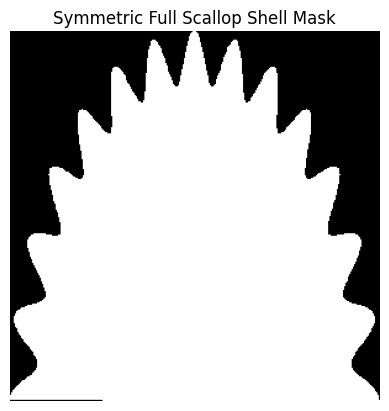

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import numpy as np
import cv2
import matplotlib.pyplot as plt

import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_full_scallop_mask(size=300, n_ridges=24, ripple_amp=0.08, radius=0.9):
    theta = np.linspace(0, np.pi, 800)  # full semicircle
    r = radius * (1 + ripple_amp * np.cos(n_ridges * theta))  # radial modulation

    # Upper arc (rippled)
    x_upper = r * np.cos(theta)
    y_upper = r * np.sin(theta)

    # Close with flat bottom edge
    x_full = np.concatenate([x_upper, [0]])   # connect ends
    y_full = np.concatenate([y_upper, [0]])   # connect to bottom

    # Normalize to image coordinates
    x_norm = (x_full - x_full.min()) / (x_full.max() - x_full.min())
    y_norm = (y_full - y_full.min()) / (y_full.max() - y_full.min())

    x_img = x_norm * (size - 1)
    y_img = (1 - y_norm) * (size - 1)  # flip y for image coords

    contour = np.array([np.stack([x_img, y_img], axis=1)], dtype=np.int32)

    # Create mask
    mask = np.zeros((size, size), dtype=np.uint8)
    cv2.fillPoly(mask, contour, 1)
    return mask

mask = generate_full_scallop_mask(size=300, n_ridges=28, ripple_amp=0.08)
plt.imshow(mask, cmap='gray')
plt.title("Symmetric Full Scallop Shell Mask")
plt.axis('off')
plt.show()




<ipython-input-7-dc2523d819da>:14: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(edges, square(3))


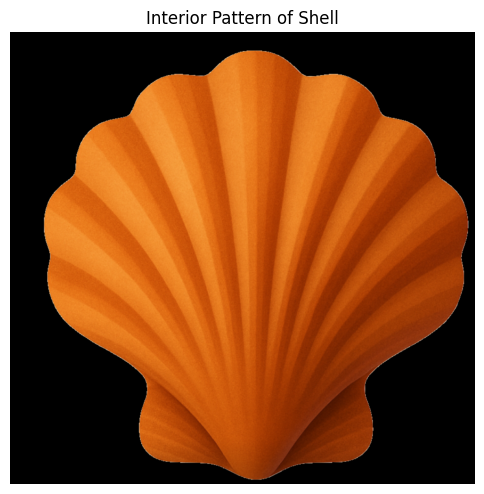

<Figure size 640x480 with 0 Axes>

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, measure, filters
from skimage.morphology import closing, square

# Step 1: Load image and convert to grayscale
img = io.imread('image2.png')  # <-- change to your actual path
img_rgb = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB) if img.shape[-1] == 4 else img
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Step 2: Edge detection and thresholding
edges = cv2.Canny(gray, 50, 150)
closed = closing(edges, square(3))
contours, _ = cv2.findContours(closed.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 3: Choose the largest contour (assume it's the shell)
shell_contour = max(contours, key=cv2.contourArea)

# Step 4: Create a mask and fill the shell interior
mask = np.zeros(gray.shape, dtype=np.uint8)
cv2.fillPoly(mask, [shell_contour], 255)

# Step 5: Apply mask to original RGB image
masked_image = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

# Step 6: Display result
plt.figure(figsize=(6,6))
plt.imshow(masked_image)
plt.title("Interior Pattern of Shell")
plt.axis('off')
plt.show()
plt.savefig('shell_masked.png')

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

gray_shell = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY)
# Find nonzero pixels inside the shell (i.e., interior)
ys, xs = np.nonzero(gray_shell)
values = gray_shell[ys, xs] / 255.0  # Normalize to [0, 1]

# Normalize coordinates to [-1, 1] for PINN input
H, W = gray_shell.shape
x_norm = (xs / W) * 2 - 1
y_norm = (ys / H) * 2 - 1
t_norm = np.zeros_like(x_norm)  # assume time = 0 for static image

# Stack into tensors for PINN
x_tensor = torch.tensor(x_norm[:, None], dtype=torch.float32)
y_tensor = torch.tensor(y_norm[:, None], dtype=torch.float32)
t_tensor = torch.tensor(t_norm[:, None], dtype=torch.float32)
u_tensor = torch.tensor(values[:, None], dtype=torch.float32)

print(x_tensor)

tensor([[0.0192],
        [0.0207],
        [0.0222],
        ...,
        [0.0784],
        [0.0799],
        [0.0814]])


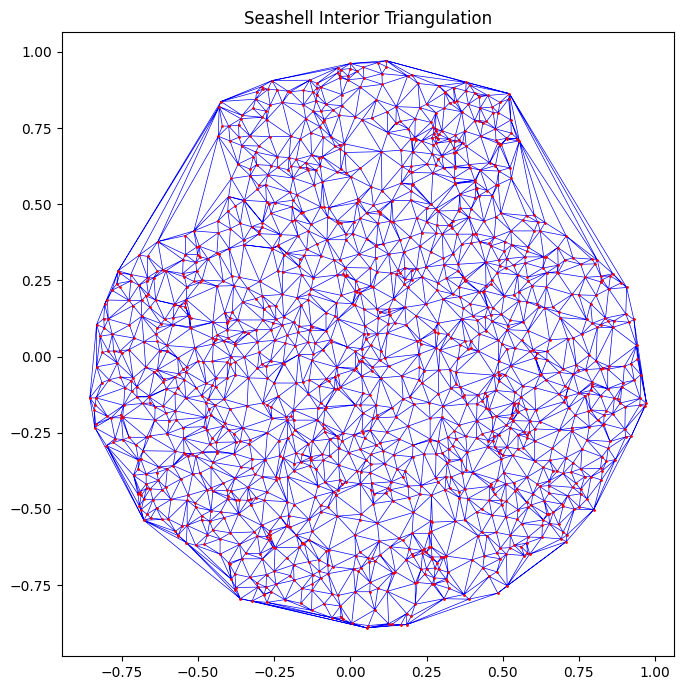

<Figure size 640x480 with 0 Axes>

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import Delaunay

# Load the new, clean image of the shell with clear black background
img_path = "shell_mask.png"
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to get binary mask
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Find contours of the white region (shell)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
shell_contour = max(contours, key=cv2.contourArea)

# Create a mask and sample points inside the shell
mask = np.zeros_like(gray)
cv2.drawContours(mask, [shell_contour], -1, 255, thickness=cv2.FILLED)

# Generate random sample points within the mask
ys, xs = np.where(mask == 255)
indices = np.random.choice(len(xs), size=1500, replace=False)
sample_points = np.vstack((xs[indices], ys[indices])).T

# Normalize points to [-1, 1] for plotting and modeling
h, w = mask.shape
normalized_points = (sample_points - np.array([[w/2, h/2]])) / np.array([[w/2, h/2]])

# Perform Delaunay triangulation on these interior points
tri = Delaunay(normalized_points)

# Plot triangulation
plt.figure(figsize=(7, 7))
plt.triplot(normalized_points[:, 0], normalized_points[:, 1], tri.simplices, color='blue', linewidth=0.5)
plt.plot(normalized_points[:, 0], normalized_points[:, 1], 'o', markersize=1, color='red')
plt.title("Seashell Interior Triangulation")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()
plt.savefig("triangulation.png")


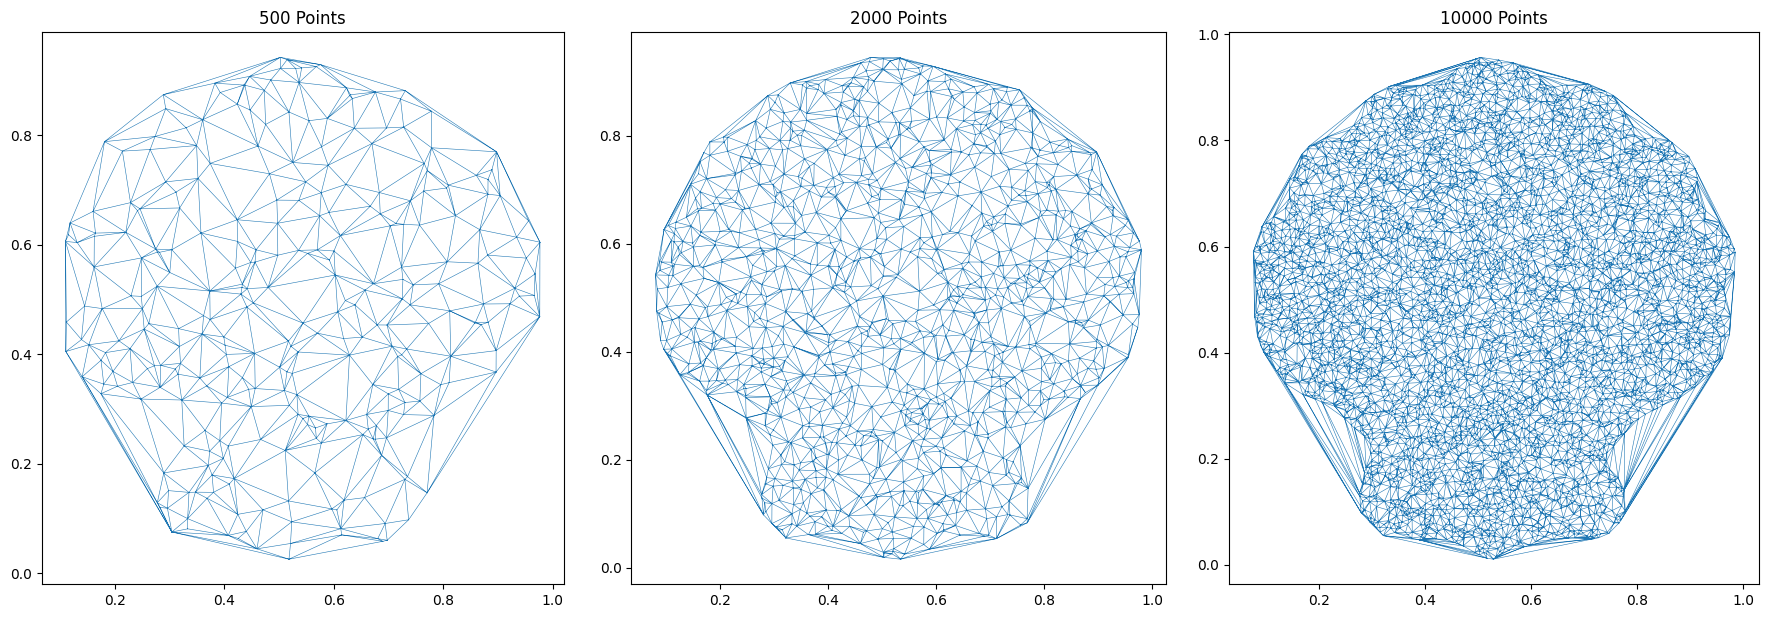

<Figure size 640x480 with 0 Axes>

In [10]:
# Re-import needed packages after kernel reset
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import Delaunay

# Reload the uploaded shell image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold to create mask of shell
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255  # binary mask

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Plot triangulations with increasing density
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
densities = [500, 2000, 10000]

for i, num_points in enumerate(densities):
    np.random.seed(0)
    rand_pts = np.random.rand(num_points, 2)
    rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
    rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

    # Keep only those inside the shell mask
    indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
    indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
    inside_mask = shell_mask[indices_y, indices_x] > 0
    mask_pts = rand_pts[inside_mask]

    # Triangulate
    tri = Delaunay(mask_pts)
    axs[i].triplot(mask_pts[:, 0], mask_pts[:, 1], tri.simplices, linewidth=0.4)
    axs[i].set_aspect('equal')
    axs[i].set_title(f'{num_points} Points')

plt.tight_layout()
plt.show()
plt.savefig("triangulations2.png")

<Figure size 640x480 with 0 Axes>

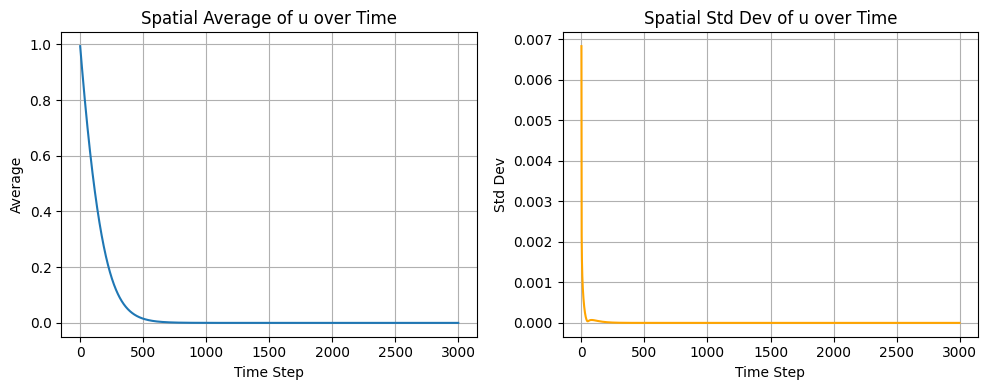

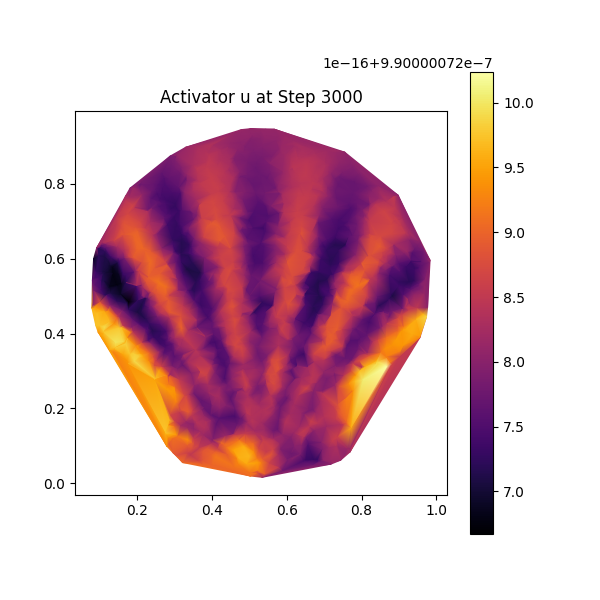

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay

import cv2

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Generate points inside shell mask
num_points = 3000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

tri = Delaunay(points)
triangles = tri.simplices

# Assemble FEM matrices
def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

def initialize_fowler_pattern(points):
    n = len(points)
    u0, v0 = 1.0, 1.0
    u = np.full(n, u0)
    v = np.full(n, v0)

    bottom_center_x = np.mean(points[:, 0])
    bottom_center_y = np.min(points[:, 1])
    center = np.array([bottom_center_x, bottom_center_y])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)

        vertical_factor = (y - bottom_center_y) / (np.max(points[:, 1]) - bottom_center_y + 1e-6)
        modulation = (1 - vertical_factor)
        perturb = 0.1 * np.cos(20 * angle) * modulation

        u[i] += perturb
        v[i] += perturb

    return u, v


u, v = initialize_fowler_pattern(points)


def fem_fowler_step(u, v, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt):
    u = np.clip(u, 1e-6, 1e3)
    v = np.clip(v, 1e-6, 1e3)

    u2 = u**2
    activation = (rho * u2) / ((v + h0) * (1 + kappa * u2 + rho0)) - mu2 * u
    inhibition = sigma + (rho * u2) / (1 + kappa * u2) - eta * v

    A_u = M + dt * Du * K
    A_v = M + dt * Dv * K
    b_u = M @ u + dt * M @ activation
    b_v = M @ v + dt * M @ inhibition

    u_new = spsolve(A_u, b_u)
    v_new = spsolve(A_v, b_v)
    return u_new, v_new


Du = 0.015
Dv = 0.0
rho = 0.1
kappa = 1.0
rho0 = 0.05
mu2 = 0.1
sigma = 0.0001
eta = 0.014
h0 = 0.1
dt = 0.1
T = 3000



import matplotlib.tri as mtri
from IPython.display import display
import PIL.Image


from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas



snapshots = []
avg_u = []
std_u = []

for t in range(T + 1):
    if t % 500 == 0:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)
        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(triang, u, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Activator u at Step {t}")
        plt.colorbar(im, ax=ax)
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        snapshots.append(PIL.Image.fromarray(image[:, :, :3]))
        plt.close(fig)
        plt.savefig(f"fowler_step_{t}.png")

    if t < T:
        u, v = fem_fowler_step(u, v, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt)
        avg_u.append(np.mean(u))
        std_u.append(np.std(u))



timesteps = np.arange(0, T)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(timesteps, avg_u, label='Spatial Average of u')
plt.xlabel('Time Step')
plt.ylabel('Average')
plt.title('Spatial Average of u over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(timesteps, std_u, label='Spatial Std Dev of u', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Std Dev')
plt.title('Spatial Std Dev of u over Time')
plt.grid(True)

plt.tight_layout()
plt.show()

snapshots[-1]

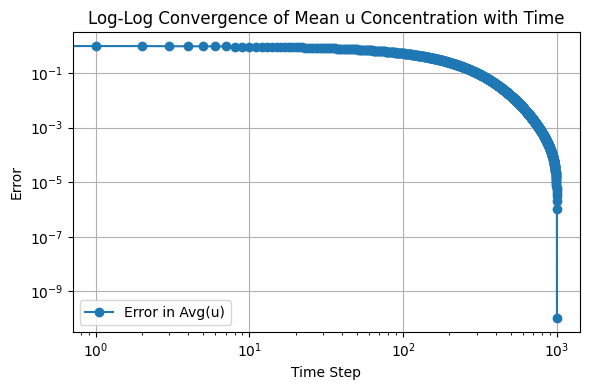

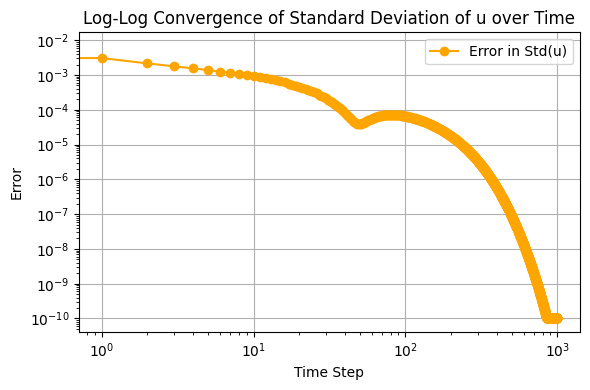

In [12]:
import numpy as np
import matplotlib.pyplot as plt

T_ref_index = 1000
avg_ref = avg_u[T_ref_index]
std_ref = std_u[T_ref_index]

# Create time step array
time_steps = np.arange(0, T_ref_index + 1)

# Compute absolute errors at each step compared to final solution
errors_avg = np.abs(np.array(avg_u[:T_ref_index + 1]) - avg_ref)
errors_std = np.abs(np.array(std_u[:T_ref_index + 1]) - std_ref)

errors_avg = np.clip(errors_avg, 1e-10, None)
errors_std = np.clip(errors_std, 1e-10, None)

# First plot: Avg(u)
plt.figure(figsize=(6, 4))
plt.loglog(time_steps, errors_avg, label='Error in Avg(u)', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Mean u Concentration with Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Second plot: Std(u)
plt.figure(figsize=(6, 4))
plt.loglog(time_steps, errors_std, label='Error in Std(u)', marker='o', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Standard Deviation of u over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


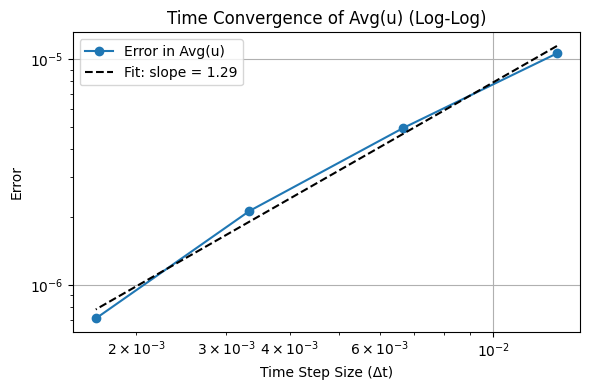

In [13]:
import numpy as np
import matplotlib.pyplot as plt

time_steps_list = [75, 150, 300, 600, 1200]
final_avg_values = []

for num_steps in time_steps_list:
    dt = 1.0 / num_steps
    u, v = initialize_fowler_pattern(points)
    for t in range(num_steps):
        u, v = fem_fowler_step(u, v, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt)
    final_avg_values.append(np.mean(u))

# Use finest time step as reference
ref_value = final_avg_values[-1]
errors = [abs(val - ref_value) for val in final_avg_values[:-1]]

# Compute dt list
dt_list = [1.0 / n for n in time_steps_list[:-1]]

# Log-log data
log_dt = np.log(dt_list)
log_err = np.log(errors)

slope, intercept = np.polyfit(log_dt, log_err, 1)
fit_line = np.exp(intercept) * np.array(dt_list)**slope

# Plot
plt.figure(figsize=(6, 4))
plt.loglog(dt_list, errors, 'o-', label='Error in Avg(u)')
plt.loglog(dt_list, fit_line, 'k--', label=f'Fit: slope = {slope:.2f}')
plt.xlabel('Time Step Size (Δt)')
plt.ylabel('Error')
plt.title('Time Convergence of Avg(u) (Log-Log)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
def fixed_point_iteration(mu2, eta, sigma, rho, rho0, kappa, h0, u0=0.1, tol=1e-10, max_iter=1000):
    u = u0
    for i in range(max_iter):
        v = (sigma + rho * u**2 / (1 + kappa * u**2)) / eta
        u_next = (mu2 / rho) * (v + h0) * (1 + kappa * u**2 + rho0)

        if abs(u_next - u) < tol:
            return u_next, i
        u = u_next
    raise RuntimeError("Fixed-point iteration did not converge")

# Parameters
mu2 = 1e-6
eta = 0.0002
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1

u_star, num_iters = fixed_point_iteration(mu2, eta, sigma, rho, rho0, kappa, h0)
v_star = (sigma + rho * u_star**2 / (1 + kappa * u_star**2)) / eta

u_star, v_star, num_iters


(6.600000239842878e-06, 0.5000000217800016, 2)

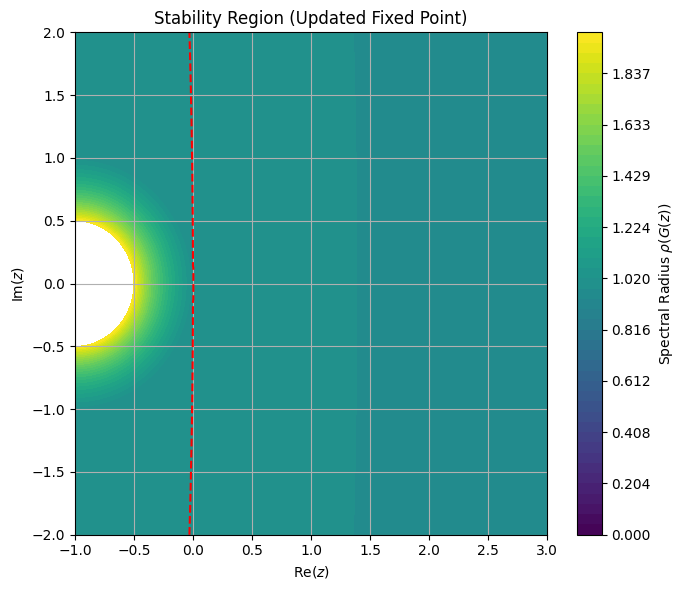

In [15]:
from numpy.linalg import eigvals
# Using the newly computed fixed point
u_star = 6.600000239842878e-06
v_star = 0.5000000217800016

# Update parameters
mu2 = 1e-6
eta = 0.0002
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1
dt = 0.1


B = 1 + kappa * u_star**2
a = mu2 * ((2 * (1 + rho)) / B - 1)
b = -mu2 * u_star / (v_star + h0)
c = (2 * rho * u_star) / (1 + kappa * u_star**2)**2
d = -eta

# Define matrices
J = np.array([[a, b],
              [c, d]])
D = np.diag([0.015, 1.0])

x_vals = np.linspace(-1, 3, 300)
y_vals = np.linspace(-2, 2, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X + 1j * Y


rho_grid = np.zeros_like(X)

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        z = Z[i, j]
        try:
            G = np.linalg.inv(np.eye(2) + z * D) @ (np.eye(2) + dt * J)
            eigs = eigvals(G)
            rho_grid[i, j] = max(abs(eigs))
        except np.linalg.LinAlgError:
            rho_grid[i, j] = np.inf

# Plot the stability region in the complex plane
levels = np.linspace(0, 2, 50)
plt.figure(figsize=(7, 6))
contourf = plt.contourf(X, Y, rho_grid, levels=levels, cmap='viridis')
plt.contour(X, Y, rho_grid, levels=[1], colors='red', linewidths=1.5, linestyles='--')

cbar = plt.colorbar(contourf)
cbar.set_label('Spectral Radius $\\rho(G(z))$')

plt.xlabel('Re$(z)$')
plt.ylabel('Im$(z)$')
plt.title('Stability Region (Updated Fixed Point)')
plt.grid(True)
plt.tight_layout()
plt.show()


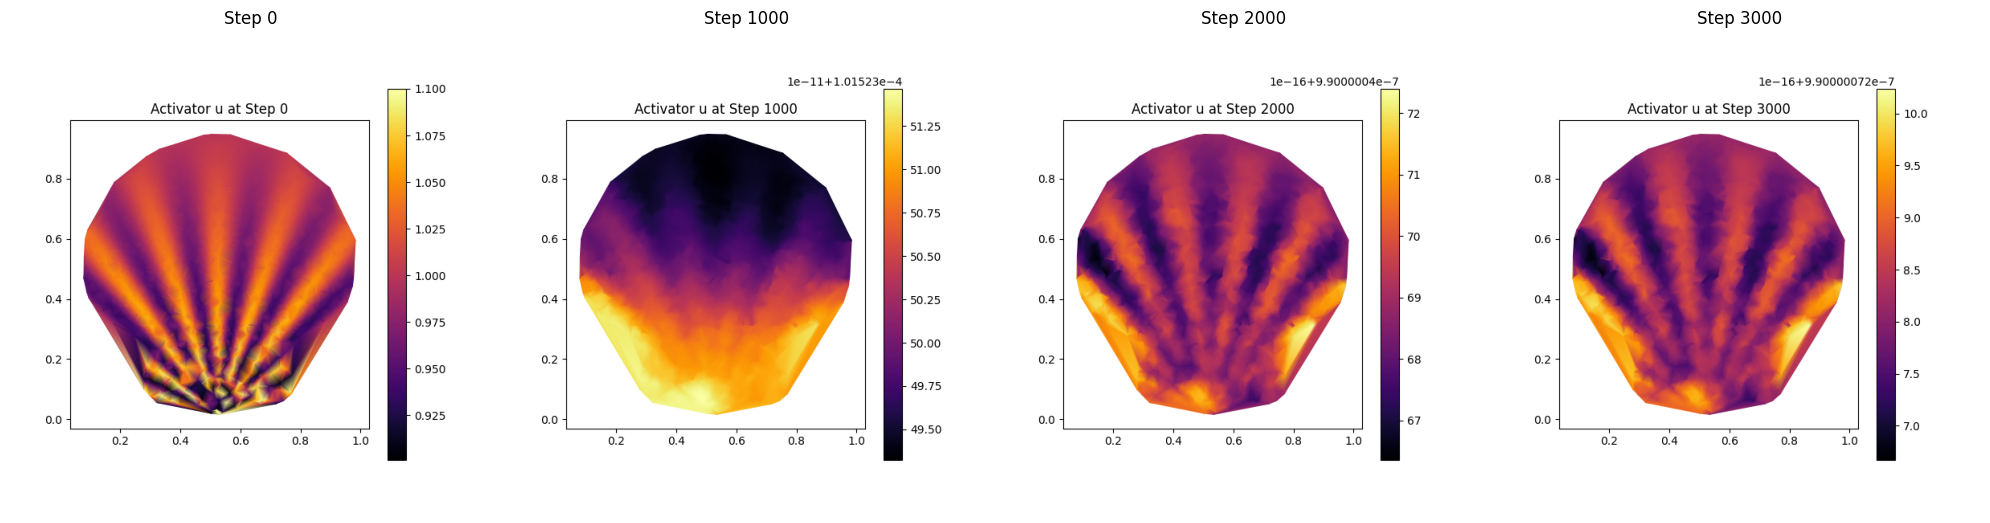

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot snapshots at specific time steps: 0, 1000, 2000, 3000
selected_steps = [0, 1000, 2000, 3000]
selected_images = []

# Map time steps to snapshots
step_to_index = {t: i for i, t in enumerate(range(0, T + 1, 500))}

for t in selected_steps:
    index = step_to_index[t]
    selected_images.append(snapshots[index])

# Plot in a single row
fig, axs = plt.subplots(1, len(selected_steps), figsize=(20, 6))
for ax, img, step in zip(axs, selected_images, selected_steps):
    ax.imshow(img)
    ax.set_title(f"Step {step}")
    ax.axis("off")
plt.tight_layout()
plt.show()
plt.savefig("snapshots.png")

In [17]:

import torch
import torch.nn as nn
import torch.optim as optim

class GM_Params(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_Da = nn.Parameter(torch.log(torch.tensor(0.005)))
        self.log_Dv = nn.Parameter(torch.log(torch.tensor(0.05)))
        self.log_rho = nn.Parameter(torch.log(torch.tensor(1.0)))
        self.log_ku  = nn.Parameter(torch.log(torch.tensor(0.03)))
        self.log_kappa = nn.Parameter(torch.log(torch.tensor(0.01)))
        self.log_mu = nn.Parameter(torch.log(torch.tensor(0.1)))

    def forward(self):
        return {
            'Du': torch.exp(self.log_Da),
            'Dv': torch.exp(self.log_Dv),
            'rho': torch.exp(self.log_rho),
            'ku':  torch.exp(self.log_ku),
            'kappa': torch.exp(self.log_kappa),
            'mu':  torch.exp(self.log_mu)
        }

def fem_gm_forward(u0, v0, M, K, params, dt=0.1, T=3000):
    u, v = u0.clone(), v0.clone()
    eps = 1e-6
    for t in range(T):
        vu2 = v**2
        f_u = params['rho'] * (vu2 - params['ku'] * u)
        f_v = params['rho'] * (vu2 / (u * (1 + params['kappa'] * vu2) + eps) - params['mu'] * v)

        A_u = M + dt * params['Du'] * K
        A_v = M + dt * params['Dv'] * K
        b_u = M @ u + dt * (M @ f_u)
        b_v = M @ v + dt * (M @ f_v)

        u = torch.linalg.solve(A_u, b_u)
        v = torch.linalg.solve(A_v, b_v)
    return u

def train_fem_pinn(a0, b0, M, K, real_img, num_epochs=200):
    model = GM_Params()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        params = model()
        u_pred = fem_gm_forward(a0, b0, M, K, params, dt=0.1, T=3000)
        loss = torch.mean((u_pred - real_img)**2)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            print({k: v.item() for k, v in params.items()})
    return model


In [18]:


import torch
import numpy as np
import cv2


a0_np, h0_np = initialize_fowler_pattern(points)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a0_torch = torch.tensor(a0_np, dtype=torch.float32, device=device)
h0_torch = torch.tensor(h0_np, dtype=torch.float32, device=device)


M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)

shell_mask_resized = cv2.resize(shell_mask, (gray_shell.shape[1], gray_shell.shape[0]), interpolation=cv2.INTER_NEAREST)
interior_values = gray_shell * shell_mask_resized
interior_normalized = interior_values / 255.0

h_img, w_img = shell_mask_resized.shape
interior_data = []

for x, y in points:
    ix = np.clip(int(x * w_img), 0, w_img - 1)
    iy = np.clip(int((1 - y) * h_img), 0, h_img - 1)
    interior_data.append(interior_normalized[iy, ix])

interior_target = torch.tensor(interior_data, dtype=torch.float32, device=device)

a0_torch.shape, h0_torch.shape, M_torch.shape, interior_target.shape


(torch.Size([1838]),
 torch.Size([1838]),
 torch.Size([1838, 1838]),
 torch.Size([1838]))

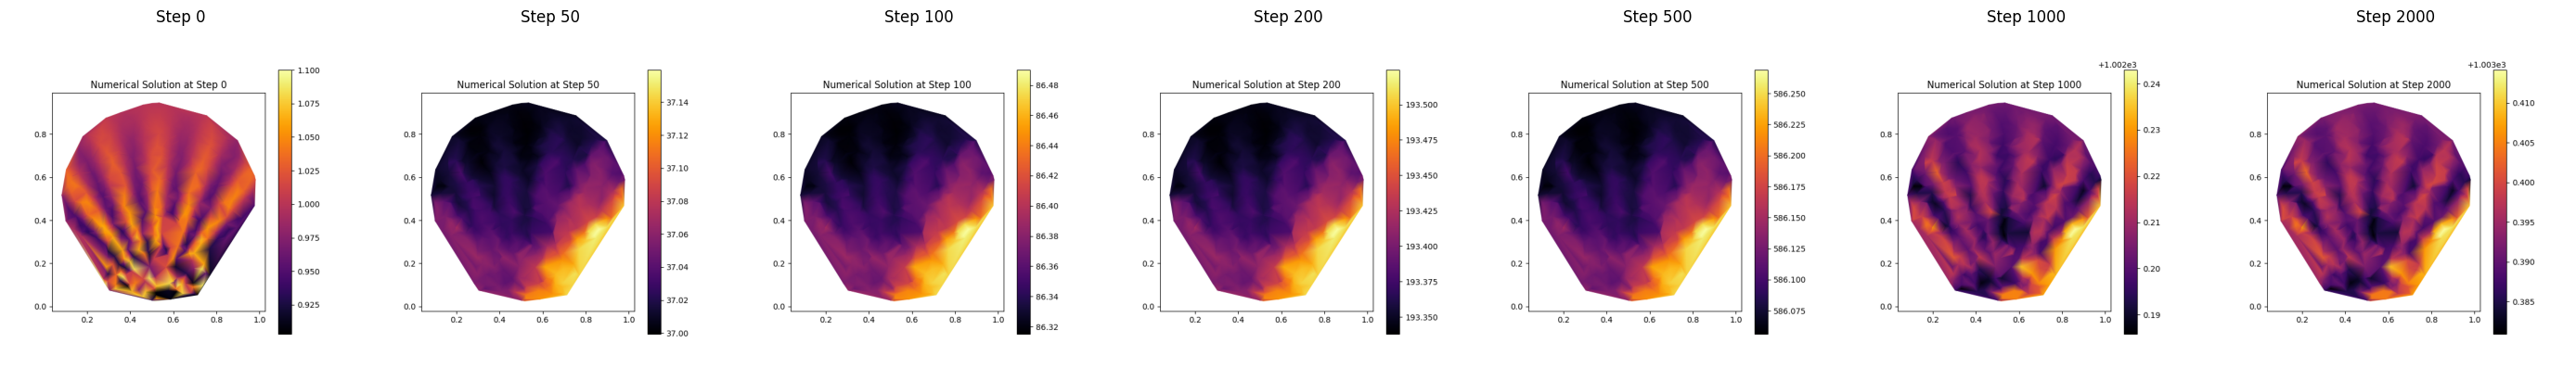

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
import matplotlib.tri as mtri
import cv2
import PIL.Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Generate points inside shell mask
num_points = 1000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

tri = Delaunay(points)
triangles = tri.simplices

# Assemble FEM matrices
def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

# Initialize activator and inhibitor
def initialize_fowler_extended_ridges(points):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)

    bottom_center_x = np.mean(points[:, 0])
    bottom_center_y = np.min(points[:, 1])
    center = np.array([bottom_center_x, bottom_center_y])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)

        vertical_factor = (y - bottom_center_y) / (np.max(points[:, 1]) - bottom_center_y + 1e-6)
        modulation = (1 - vertical_factor)
        perturb = 0.1 * np.cos(20 * angle) * modulation

        a[i] += perturb
        h[i] += perturb

    return a, h

a, h = initialize_fowler_extended_ridges(points)


def fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt):
    a = np.clip(a, 1e-6, 1e3)
    h = np.clip(h, 1e-6, 1e3)

    a2 = a**2
    activation = (a2 / (1 + rho * a2)) / (h + h0) + eps0 - mu * a
    inhibition = eta * (a2 / (1 + rho * a2)) - gamma * h

    A_a = M + dt * Da * K
    A_h = M + dt * Dh * K
    b_a = M @ a + dt * M @ activation
    b_h = M @ h + dt * M @ inhibition

    a_new = spsolve(A_a, b_a)
    h_new = spsolve(A_h, b_h)
    return a_new, h_new


Da = 0.015
Dh = 0.0
rho = 0.1
eps0 = 0.0001
mu = 1e-6
eta = 0.0002
gamma = 0.014
h0 = 0.1
dt = 0.1
T = 3000

# Steps we want to capture
save_steps = [0, 50, 100, 200, 500, 1000, 2000]

# Main time loop
snapshots = []

for t in range(T + 1):
    if t in save_steps:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)
        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(triang, a, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Numerical Solution at Step {t}")
        plt.colorbar(im, ax=ax)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        image_rgb = image[:, :, :3]
        snapshots.append(PIL.Image.fromarray(image_rgb))
        plt.close(fig)

    if t < T:
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, rho, eps0, mu, eta, gamma, h0, dt)


fig, axes = plt.subplots(1, len(snapshots), figsize=(4 * len(snapshots), 4))

for i, ax in enumerate(axes):
    ax.imshow(snapshots[i])
    ax.set_title(f"Step {save_steps[i]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("combined_snapshots.png")
plt.show()


In [20]:
# Initialization (already defined earlier)
u0_np, v0_np = initialize_fowler_pattern(points)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
u0_torch = torch.tensor(u0_np, dtype=torch.float32, device=device)
v0_torch = torch.tensor(v0_np, dtype=torch.float32, device=device)

M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)

# Process real shell image into a FEM-target tensor, emphasizing dark features
shell_mask_resized = cv2.resize(shell_mask, (gray_shell.shape[1], gray_shell.shape[0]), interpolation=cv2.INTER_NEAREST)
interior_values = gray_shell * shell_mask_resized
interior_normalized = interior_values / 255.0

# Emphasize darker regions (e.g., shadows or pigment lines)
emphasized = 1.0 - interior_normalized  # or try: np.exp(-interior_normalized)

h_img, w_img = shell_mask_resized.shape
interior_data = []

for x, y in points:
    ix = np.clip(int(x * w_img), 0, w_img - 1)
    iy = np.clip(int((1 - y) * h_img), 0, h_img - 1)
    interior_data.append(emphasized[iy, ix])

interior_target = torch.tensor(interior_data, dtype=torch.float32, device=device)

<Figure size 640x480 with 0 Axes>

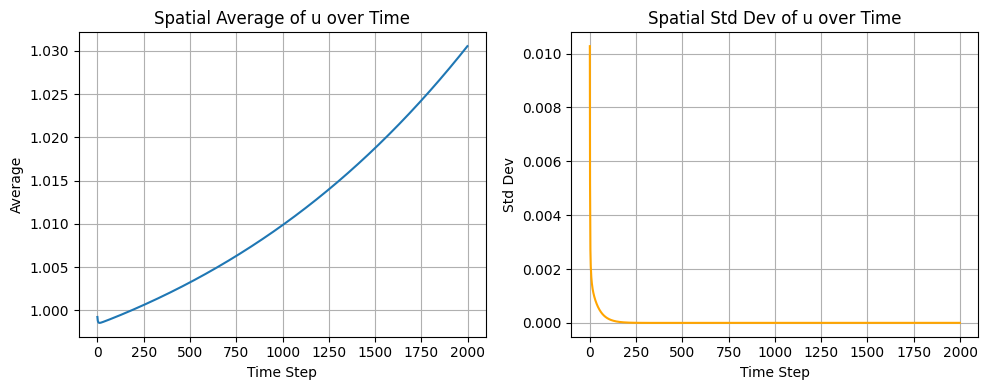

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
import cv2
import matplotlib.tri as mtri
import PIL.Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Generate random points and filter inside the shell
num_points = 3000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min
indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

# Delaunay triangulation
tri = Delaunay(points)
triangles = tri.simplices

# Assemble FEM matrices
def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))
    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = points[i], points[j], points[k]
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))
        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T
        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6
    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)


def initialize_fowler_pattern(points):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)

    bottom_center_x = np.mean(points[:, 0])
    bottom_center_y = np.min(points[:, 1])
    center = np.array([bottom_center_x, bottom_center_y])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)

        vertical_factor = (y - bottom_center_y) / (np.max(points[:, 1]) - bottom_center_y + 1e-6)
        modulation = (1 - vertical_factor)
        perturb = 0.1 * np.cos(20 * angle) * modulation

        a[i] += perturb
        h[i] += perturb

    return a, h




# Initialize activator u and inhibitor v
def initialize_assume_pattern(points, interior_target, scale=0.2, vertical_emphasis=2.0):
    """
    Initialize u, v fields using real image target to guide the initial condition.
    The target is attenuated toward the top of the shell to simulate biological pattern origin.
    """
    n = len(points)
    u = np.full(n, 1.0)
    v = np.full(n, 1.0)

    y_coords = points[:, 1]
    bottom_y = np.min(y_coords)
    vertical_weight = (1 - (y_coords - bottom_y) / (np.max(y_coords) - bottom_y + 1e-6)) ** vertical_emphasis

    # Normalize the real target pattern
    target = interior_target.detach().cpu().numpy()
    target = (target - target.min()) / (target.max() - target.min() + 1e-6)

    # Perturb using a scaled version of the image pattern, stronger at the base
    perturb = scale * vertical_weight * (target - 0.5)  # center around 0
    u += perturb
    v += perturb

    return u, v

# FEM step for Fowler model
def fem_fowler_step(u, v, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt):
    u = np.clip(u, 1e-6, 1e3)
    v = np.clip(v, 1e-6, 1e3)
    u2 = u**2
    activation = (rho * u2) / ((v + h0) * (1 + kappa * u2 + rho0)) - mu2 * u
    inhibition = sigma + (rho * u2) / (1 + kappa * u2) - eta * v
    A_u = M + dt * Du * K
    A_v = M + dt * Dv * K
    b_u = M @ u + dt * M @ activation
    b_v = M @ v + dt * M @ inhibition
    u_new = spsolve(A_u, b_u)
    v_new = spsolve(A_v, b_v)
    return u_new, v_new

# Parameters from Fowler et al.
Du = 0.015
Dv = 0.0
rho = 0.0002
kappa = 0.1
rho0 = 0.1
mu2 = 1e-6
sigma = 0.000
eta = 0.014
h0 = 0.1
dt = 0.05
T = 2000

# Run simulation
u, v = initialize_fowler_pattern(points)

snapshots = []
avg_u = []
std_u = []

for t in range(T + 1):
    if t % 500 == 0:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)
        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(triang, u, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Activator u at Step {t}")
        plt.colorbar(im, ax=ax)
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        snapshots.append(PIL.Image.fromarray(image[:, :, :3]))
        plt.close(fig)
        plt.savefig(f"fowler_step_{t}.png")
    if t < T:
        u, v = fem_fowler_step(u, v, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt)
        avg_u.append(np.mean(u))
        std_u.append(np.std(u))

# Plot time evolution of spatial statistics
timesteps = np.arange(0, T)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(timesteps, avg_u, label='Spatial Average of u')
plt.xlabel('Time Step')
plt.ylabel('Average')
plt.title('Spatial Average of u over Time')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(timesteps, std_u, label='Spatial Std Dev of u', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Std Dev')
plt.title('Spatial Std Dev of u over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


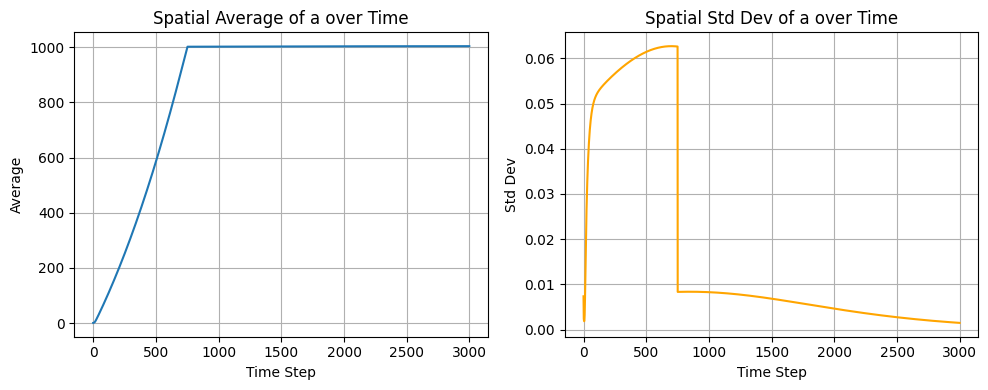

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay

import cv2

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

num_points = 3000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

tri = Delaunay(points)
triangles = tri.simplices

# Assemble FEM matrices
def assemble_fem_matrices(points, triangles):
    n = len(points)
    M = lil_matrix((n, n))
    K = lil_matrix((n, n))

    for tri in triangles:
        i, j, k = tri
        p0, p1, p2 = np.array(points[i]), np.array(points[j]), np.array(points[k])
        mat_T = np.array([[p1[0] - p0[0], p2[0] - p0[0]], [p1[1] - p0[1], p2[1] - p0[1]]])
        area = 0.5 * abs(np.linalg.det(mat_T))

        inv_J = np.linalg.inv(mat_T)
        grad_phi_ref = np.array([[-1, -1], [1, 0], [0, 1]])
        grad_phi_phys = grad_phi_ref @ inv_J.T

        for a in range(3):
            for b in range(3):
                K[tri[a], tri[b]] += area * np.dot(grad_phi_phys[a], grad_phi_phys[b])
                M[tri[a], tri[b]] += area / 12 if a != b else area / 6

    return M.tocsr(), K.tocsr()

M, K = assemble_fem_matrices(points, triangles)

# Initialize activator and inhibitor
def initialize_fowler_extended_ridges(points):
    n = len(points)
    a0, h0 = 1.0, 1.0
    a = np.full(n, a0)
    h = np.full(n, h0)

    # Use bottom-center as origin
    bottom_center_x = np.mean(points[:, 0])
    bottom_center_y = np.min(points[:, 1])
    center = np.array([bottom_center_x, bottom_center_y])

    for i, (x, y) in enumerate(points):
        dx, dy = x - center[0], y - center[1]
        angle = np.arctan2(dy, dx)


        vertical_factor = (y - bottom_center_y) / (np.max(points[:, 1]) - bottom_center_y + 1e-6)
        modulation = (1 - vertical_factor)
        perturb = 0.1 * np.cos(20 * angle) * modulation

        a[i] += perturb
        h[i] += perturb

    return a, h

a, h = initialize_fowler_extended_ridges(points)

# FEM step using Fowler equations
def fem_fowler_step(a, h, M, K, Da, Dh, kappa, sigma, rho0, mu, rho, eta, h0, dt):
    a = np.clip(a, 1e-6, 1e3)
    h = np.clip(h, 1e-6, 1e3)

    a2 = a**2
    activation = (a2 / (1 + kappa * a2 + rho0)) / (h + h0)  - mu * a
    inhibition = sigma + rho * (a2 / (1 + kappa * a2)) - eta * h

    A_a = M + dt * Da * K
    A_h = M + dt * Dh * K
    b_a = M @ a + dt * M @ activation
    b_h = M @ h + dt * M @ inhibition

    a_new = spsolve(A_a, b_a)
    h_new = spsolve(A_h, b_h)
    return a_new, h_new

# Parameters from Fowler et al. (1992)
Da = 0.015
Dh = 0.0
kappa = 0.1
sigma = 0.0001
rho0 = 0.1
mu = 1e-6
rho = 0.0002
eta = 0.014
h0 = 0.1
dt = 0.1
T = 3000




import matplotlib.tri as mtri
from IPython.display import display
import PIL.Image

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

snapshots = []
avg_a = []
std_a = []

for t in range(T + 1):
    if t in [0, 50, 200, 1000, 2000]:
        fig, ax = plt.subplots(figsize=(6, 6))
        FigureCanvas(fig)  # Attach a canvas explicitly

        triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
        im = ax.tripcolor(triang, a, shading='gouraud', cmap='inferno')
        ax.set_aspect('equal')
        ax.set_title(f"Activator a at Step {t}")
        plt.colorbar(im, ax=ax)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        snapshots.append(PIL.Image.fromarray(image[:, :, :3]))
        plt.savefig(f"second_step_{t}.png")
        plt.close(fig)

    if t < T:
        a, h = fem_fowler_step(a, h, M, K, Da, Dh, kappa, sigma, rho0, mu, rho, eta, h0, dt)
        avg_a.append(np.mean(a))
        std_a.append(np.std(a))


snapshots[-1]

timesteps = np.arange(0, T)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(timesteps, avg_a, label='Spatial Average of a')
plt.xlabel('Time Step')
plt.ylabel('Average')
plt.title('Spatial Average of a over Time')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(timesteps, std_a, label='Spatial Std Dev of a', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Std Dev')
plt.title('Spatial Std Dev of a over Time')
plt.grid(True)

plt.tight_layout()
plt.show()



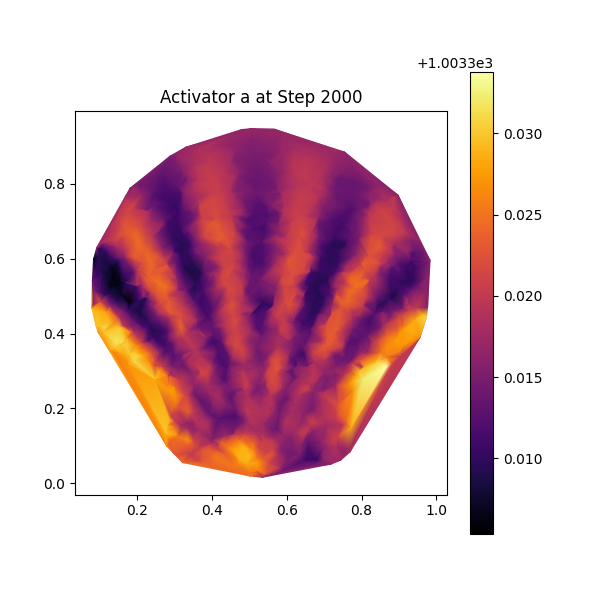

In [72]:

snapshots[-1]

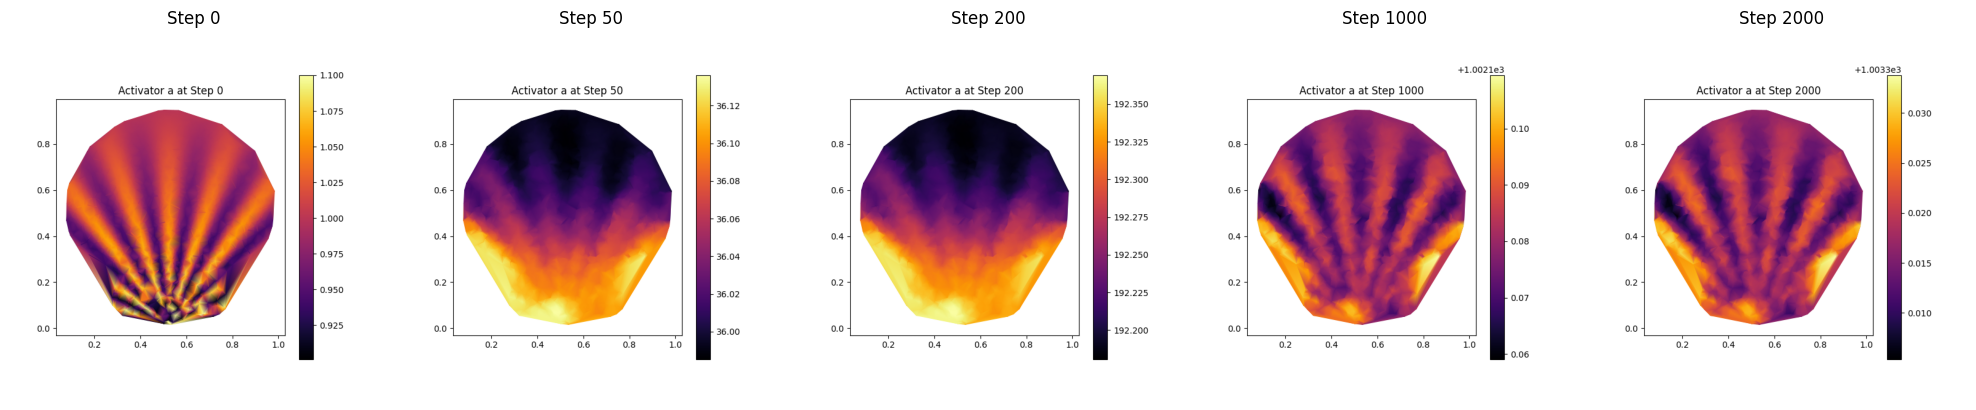

In [73]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the steps you saved
save_steps = [0, 50, 200, 1000, 2000]

# Load and plot them in one row
fig, axes = plt.subplots(1, len(save_steps), figsize=(20, 4))
for i, step in enumerate(save_steps):
    img = mpimg.imread(f"second_step_{step}.png")
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Step {step}")

plt.tight_layout()
plt.show()


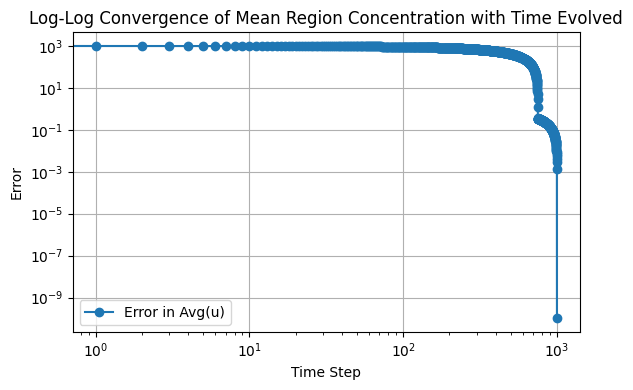

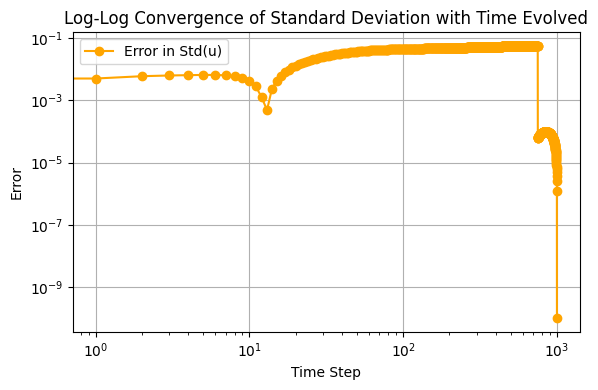

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Use reference index for Fowler model's activator u
T_ref_index = 1000
avg_ref = avg_a[T_ref_index]
std_ref = std_a[T_ref_index]

# Time step array
time_steps = np.arange(0, T_ref_index + 1)

# Absolute errors compared to reference
errors_avg = np.abs(np.array(avg_a[:T_ref_index + 1]) - avg_ref)
errors_std = np.abs(np.array(std_a[:T_ref_index + 1]) - std_ref)

# Prevent log(0)
errors_avg = np.clip(errors_avg, 1e-10, None)
errors_std = np.clip(errors_std, 1e-10, None)

# Plot log-log convergence of mean
plt.figure(figsize=(6, 4))
plt.loglog(time_steps, errors_avg, label='Error in Avg(u)', marker='o')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Mean Region Concentration with Time Evolved')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot log-log convergence of standard deviation
plt.figure(figsize=(6, 4))
plt.loglog(time_steps, errors_std, label='Error in Std(u)', marker='o', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Error')
plt.title('Log-Log Convergence of Standard Deviation with Time Evolved')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


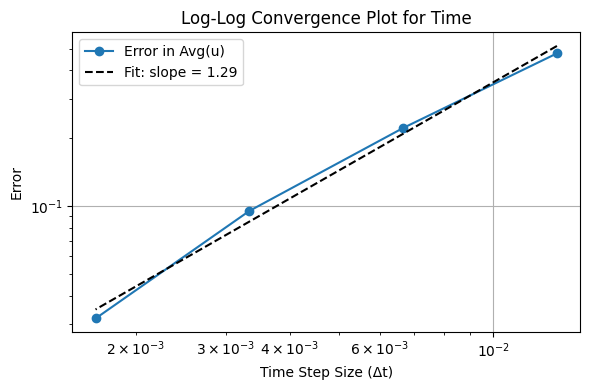

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Time steps to test convergence
time_steps_list = [75, 150, 300, 600, 1200]
final_avg_values = []

for num_steps in time_steps_list:
    dt = 1.0 / num_steps
    u, v = initialize_fowler_extended_ridges(points)  # updated initializer
    for t in range(num_steps):
        u, v = fem_fowler_step(a, h, M, K, Da, Dh, kappa, sigma, rho0, mu, rho, eta, h0, dt)
    final_avg_values.append(np.mean(u))

# Use the finest time step as the reference value
ref_value = final_avg_values[-1]
errors = [abs(val - ref_value) for val in final_avg_values[:-1]]

# Corresponding dt values (excluding the finest one)
dt_list = [1.0 / n for n in time_steps_list[:-1]]

# Fit slope on log-log scale
log_dt = np.log(dt_list)
log_err = np.log(errors)
slope, intercept = np.polyfit(log_dt, log_err, 1)
fit_line = np.exp(intercept) * np.array(dt_list)**slope

# Plot log-log convergence
plt.figure(figsize=(6, 4))
plt.loglog(dt_list, errors, 'o-', label='Error in Avg(u)')
plt.loglog(dt_list, fit_line, 'k--', label=f'Fit: slope = {slope:.2f}')
plt.xlabel('Time Step Size (Δt)')
plt.ylabel('Error')
plt.title('Log-Log Convergence Plot for Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


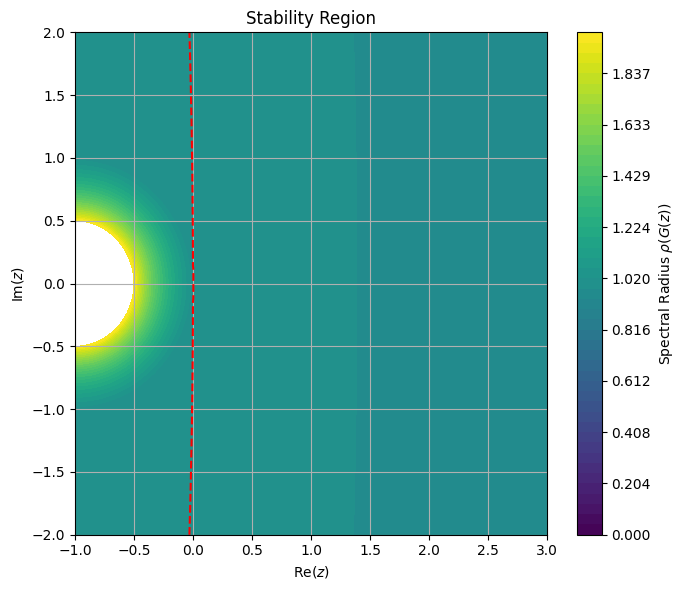

In [63]:
def fixed_point_iteration(mu2, eta, sigma, rho, rho0, kappa, h0, u0=0.1, tol=1e-10, max_iter=1000):
    u = u0
    for i in range(max_iter):
        v = (sigma + rho * u**2 / (1 + kappa * u**2)) / eta
        u_next = (mu2 / rho) * (v + h0) * (1 + kappa * u**2 + rho0)

        if abs(u_next - u) < tol:
            return u_next, i
        u = u_next
    raise RuntimeError("Fixed-point iteration did not converge")

# Parameters
mu2 = 1e-6
eta = 0.014
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 0.1
h0 = 0.1


u_star, num_iters = fixed_point_iteration(mu2, eta, sigma, rho, rho0, kappa, h0)
v_star = (sigma + rho * u_star**2 / (1 + kappa * u_star**2)) / eta

u_star, v_star, num_iters

from numpy.linalg import eigvals

u_star = 6.600000239842878e-06
v_star = 0.5000000217800016

# Update parameters
mu2 = 1e-6
eta = 0.014
sigma = 0.0001
rho = 0.1
rho0 = 0.1
kappa = 1.0
h0 = 0.1
dt = 0.1

B = 1 + kappa * u_star**2
a = mu2 * ((2 * (1 + rho)) / B - 1)
b = -mu2 * u_star / (v_star + h0)
c = (2 * rho * u_star) / (1 + kappa * u_star**2)**2
d = -eta

# Define matrices
J = np.array([[a, b],
              [c, d]])
D = np.diag([0.015, 1.0])


x_vals = np.linspace(-1, 3, 300)
y_vals = np.linspace(-2, 2, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X + 1j * Y


rho_grid = np.zeros_like(X)

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        z = Z[i, j]
        try:
            G = np.linalg.inv(np.eye(2) + z * D) @ (np.eye(2) + dt * J)
            eigs = eigvals(G)
            rho_grid[i, j] = max(abs(eigs))
        except np.linalg.LinAlgError:
            rho_grid[i, j] = np.inf

# Plot the stability region in the complex plane
levels = np.linspace(0, 2, 50)
plt.figure(figsize=(7, 6))
contourf = plt.contourf(X, Y, rho_grid, levels=levels, cmap='viridis')
plt.contour(X, Y, rho_grid, levels=[1], colors='red', linewidths=1.5, linestyles='--')

cbar = plt.colorbar(contourf)
cbar.set_label('Spectral Radius $\\rho(G(z))$')

plt.xlabel('Re$(z)$')
plt.ylabel('Im$(z)$')
plt.title('Stability Region')
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
import torch
import numpy as np
import cv2

# Initialization (already defined earlier)
u0_np, v0_np = initialize_fowler_pattern(points)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
u0_torch = torch.tensor(u0_np, dtype=torch.float32, device=device)
v0_torch = torch.tensor(v0_np, dtype=torch.float32, device=device)

M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)

# Step 1: Resize shell mask to match grayscale image size
shell_mask_resized = cv2.resize(shell_mask, (gray_shell.shape[1], gray_shell.shape[0]), interpolation=cv2.INTER_NEAREST)

# Step 2: Apply adaptive histogram equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4, 4))
gray_enhanced = clahe.apply(gray_shell)

# Step 3: Normalize and apply shell mask
gray_norm = gray_enhanced.astype(np.float32) / 255.0
masked_enhanced = gray_norm * shell_mask_resized

# Step 4: Nonlinear transformation to emphasize ridge contrast
ridge_emphasis = 1.0 - np.power(masked_enhanced, 0.5)  # gamma correction brightens
ridge_emphasis = np.clip(ridge_emphasis, 0, 1)

# Optional piecewise exaggeration (tunable)
# ridge_emphasis[ridge_emphasis < 0.3] *= 0.7  # deepen valleys
# ridge_emphasis[ridge_emphasis > 0.6] *= 1.3  # boost peaks
# ridge_emphasis = np.clip(ridge_emphasis, 0, 1)

# Step 5: Sample FEM-target values from enhanced image
h_img, w_img = ridge_emphasis.shape
interior_data = []
for x, y in points:
    ix = np.clip(int(x * w_img), 0, w_img - 1)
    iy = np.clip(int((1 - y) * h_img), 0, h_img - 1)
    interior_data.append(ridge_emphasis[iy, ix])

# Convert to torch tensor for training
interior_target = torch.tensor(interior_data, dtype=torch.float32, device=device)


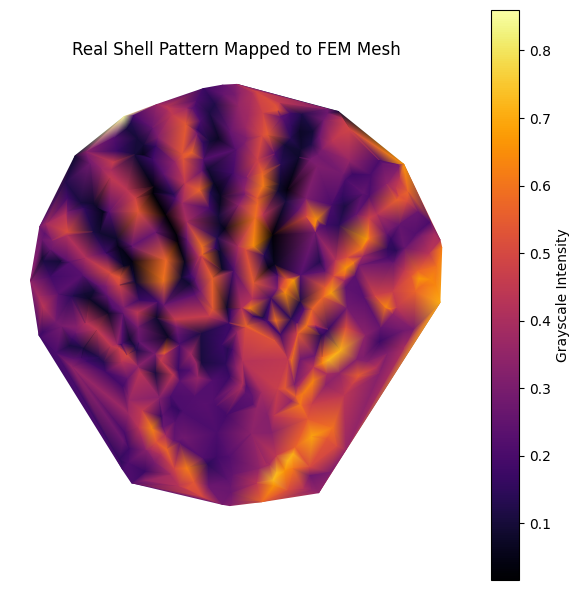

In [28]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import torch

# Convert the real image data back to CPU for plotting
real_pattern = interior_target.detach().cpu().numpy()

# Triangulation object from points and triangles
triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)

# Plot the real shell pattern mapped to FEM mesh
plt.figure(figsize=(6, 6))
plt.tripcolor(triang, real_pattern, shading='gouraud', cmap='inferno')
plt.gca().set_aspect('equal')
plt.title("Real Shell Pattern Mapped to FEM Mesh")
plt.colorbar(label='Grayscale Intensity')
plt.axis('off')
plt.tight_layout()
plt.show()


Matrix M shape: torch.Size([591, 591])
Initial u shape: torch.Size([591])
Real image target shape: torch.Size([591])
Epoch 0: L_total = 0.595779, L_data = 0.498623, L_phys = 0.097156
Epoch 10: L_total = 0.462673, L_data = 0.371145, L_phys = 0.091528
Epoch 20: L_total = 0.386816, L_data = 0.267511, L_phys = 0.119305
Epoch 30: L_total = 0.271975, L_data = 0.187426, L_phys = 0.084549
Epoch 40: L_total = 0.182245, L_data = 0.128482, L_phys = 0.053764
Epoch 50: L_total = 0.130121, L_data = 0.087771, L_phys = 0.042350
Epoch 60: L_total = 0.088764, L_data = 0.061071, L_phys = 0.027692
Epoch 70: L_total = 0.067398, L_data = 0.044446, L_phys = 0.022952
Epoch 80: L_total = 0.058173, L_data = 0.034551, L_phys = 0.023621
Epoch 90: L_total = 0.056373, L_data = 0.028874, L_phys = 0.027498
Epoch 100: L_total = 0.038253, L_data = 0.025834, L_phys = 0.012418
Epoch 110: L_total = 0.036187, L_data = 0.024237, L_phys = 0.011950
Epoch 120: L_total = 0.033095, L_data = 0.023359, L_phys = 0.009736
Epoch 130:

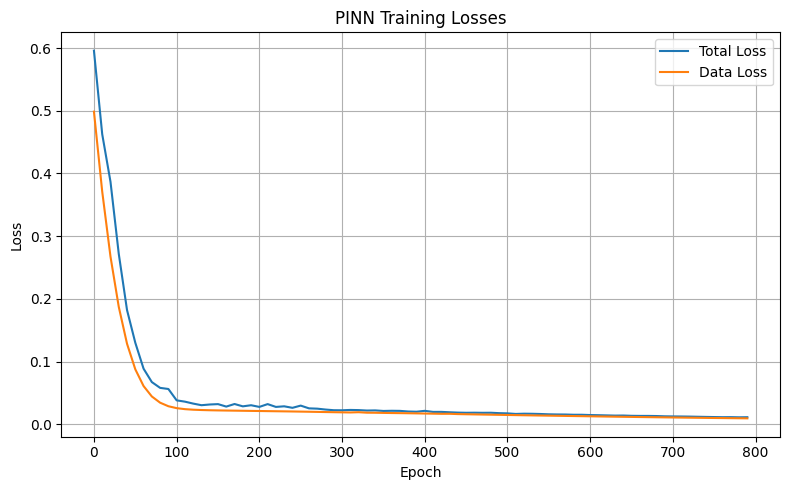

In [29]:
def train_fem_pinn_with_initial_learning(u0, v0, M, K, real_img, num_epochs=300, dt=0.01, T=10):
    class FowlerParams(nn.Module):
        def __init__(self):
            super().__init__()
            self.log_Du = nn.Parameter(torch.log(torch.tensor(0.015)))
            self.log_Dv = nn.Parameter(torch.log(torch.tensor(0.001)))
            self.log_rho = nn.Parameter(torch.log(torch.tensor(0.1)))
            self.log_kappa = nn.Parameter(torch.log(torch.tensor(1.0)))
            self.log_rho0 = nn.Parameter(torch.log(torch.tensor(0.05)))
            self.log_mu2 = nn.Parameter(torch.log(torch.tensor(1e-6)))
            self.log_sigma = nn.Parameter(torch.log(torch.tensor(0.0001)))
            self.log_eta = nn.Parameter(torch.log(torch.tensor(0.0002)))
            self.h0 = 0.1

        def forward(self):
            return {
                'Du': torch.exp(self.log_Du),
                'Dv': torch.exp(self.log_Dv),
                'rho': torch.exp(self.log_rho),
                'kappa': torch.exp(self.log_kappa),
                'rho0': torch.exp(self.log_rho0),
                'mu2': torch.exp(self.log_mu2),
                'sigma': torch.exp(self.log_sigma),
                'eta': torch.exp(self.log_eta),
                'h0': self.h0
            }

    model = FowlerParams().to(u0.device)

    u0_param = nn.Parameter(u0.clone().detach())
    v0_param = nn.Parameter(v0.clone().detach())

    optimizer = optim.Adam(list(model.parameters()) + [u0_param, v0_param], lr=1e-2)
    loss_history = {'epoch': [], 'total': [], 'data': []}
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        params = model()

        u, v = u0_param, v0_param
        loss_phys = 0

        for t in range(T):
            u2 = u**2
            activation = (params['rho'] * u2) / ((v + params['h0']) * (1 + params['kappa'] * u2 + params['rho0']) + 1e-6) - params['mu2'] * u
            inhibition = params['sigma'] + (params['rho'] * u2) / (1 + params['kappa'] * u2 + 1e-6) - params['eta'] * v

            A_u = M + dt * params['Du'] * K
            A_v = M + dt * params['Dv'] * K
            b_u = M @ u + dt * (M @ activation)
            b_v = M @ v + dt * (M @ inhibition)

            u_new = torch.linalg.solve(A_u, b_u)
            v_new = torch.linalg.solve(A_v, b_v)

            Ru = (M @ (u_new - u) / dt) + params['Du'] * (K @ u_new) - (M @ activation)
            Rv = (M @ (v_new - v) / dt) + params['Dv'] * (K @ v_new) - (M @ inhibition)
            loss_phys += (torch.norm(Ru)**2 + torch.norm(Rv)**2) * 1e10

            u, v = u_new, v_new

        loss_data = torch.mean((u - real_img) ** 2)
        loss_total = loss_data + loss_phys
        loss_total.backward()
        optimizer.step()


        if epoch % 10 == 0:
          loss_history['epoch'].append(epoch)
          loss_history['total'].append(loss_total.item())
          loss_history['data'].append(loss_data.item())
          print(f"Epoch {epoch}: L_total = {loss_total.item():.6f}, L_data = {loss_data.item():.6f}, L_phys = {loss_phys.item():.6f}")


    return model, u0_param.detach(), v0_param.detach(), loss_history

# Generate initial u and v using your analytical initializer
u0_np, v0_np = initialize_fowler_pattern(points)  # points shape = (n, 2)
assert u0_np.shape == v0_np.shape == (len(points),)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
u0_torch = torch.tensor(u0_np, dtype=torch.float32, device=device)
v0_torch = torch.tensor(v0_np, dtype=torch.float32, device=device)

# Convert FEM matrices to torch tensors
M_torch = torch.tensor(M.toarray(), dtype=torch.float32, device=device)
K_torch = torch.tensor(K.toarray(), dtype=torch.float32, device=device)

# Check real_img (interior_target) shape consistency
assert interior_target.shape[0] == u0_torch.shape[0], \
    f"Shape mismatch: interior_target ({interior_target.shape}) vs u0 ({u0_torch.shape})"

# Debug print
print("Matrix M shape:", M_torch.shape)
print("Initial u shape:", u0_torch.shape)
print("Real image target shape:", interior_target.shape)

# Run training with learnable initial conditions
trained_model, u0_learned, v0_learned, loss_history = train_fem_pinn_with_initial_learning(
    u0=u0_torch,
    v0=v0_torch,
    M=M_torch,
    K=K_torch,
    real_img=interior_target,
    num_epochs=800
)

# Extract final parameters from the trained model
final_params = trained_model()


plt.figure(figsize=(8, 5))
plt.plot(loss_history['epoch'], loss_history['total'], label='Total Loss')
plt.plot(loss_history['epoch'], loss_history['data'], label='Data Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('PINN Training Losses')
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
print(loss_history["epoch"])
print(loss_history["total"])
print(loss_history["data"])

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790]
[0.5957790017127991, 0.4626731872558594, 0.3868156373500824, 0.2719750702381134, 0.1822453886270523, 0.13012062013149261, 0.08876354992389679, 0.06739778071641922, 0.05817258730530739, 0.056372612714767456, 0.03825261443853378, 0.03618650883436203, 0.0330953486263752, 0.030526574701070786, 0.03165532648563385, 0.03225012868642807, 0.028324387967586517, 0.0324358195066452, 0.028714239597320557, 0.03047206625342369, 0.027826514095067978, 0.03227598965167999, 0.0277975182980299, 0.028763622045516968, 0.02635342627763748, 0.02988421358168125, 0.025501742959022522, 0.02501487359404564, 0.02360190637409687, 0

M shape: (591, 591)
K shape: (591, 591)
(591, 2)
(1160, 3)


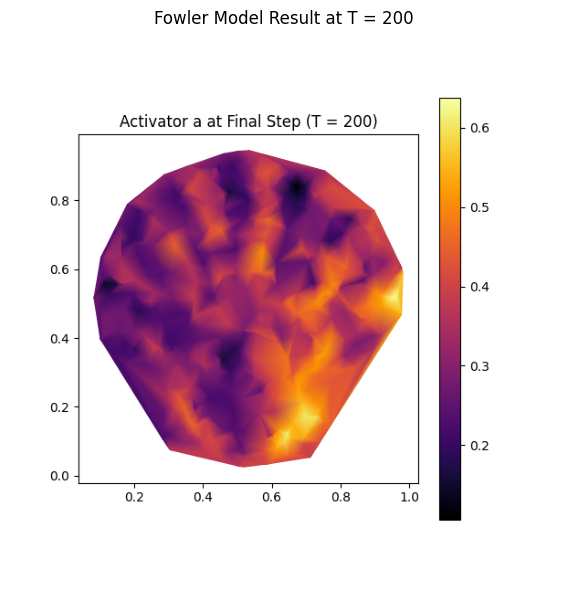

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.spatial import Delaunay
import cv2
import matplotlib.tri as mtri
import PIL.Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Load and process shell mask image
image_path = 'shell_mask.png'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
shell_mask = mask // 255

# Normalize dimensions
h, w = shell_mask.shape
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Generate points inside shell mask
num_points = 1000
np.random.seed(0)
rand_pts = np.random.rand(num_points, 2)
rand_pts[:, 0] = rand_pts[:, 0] * (x_max - x_min) + x_min
rand_pts[:, 1] = rand_pts[:, 1] * (y_max - y_min) + y_min

indices_x = np.clip((rand_pts[:, 0] * w).astype(int), 0, w - 1)
indices_y = np.clip(((1 - rand_pts[:, 1]) * h).astype(int), 0, h - 1)
inside_mask = shell_mask[indices_y, indices_x] > 0
points = rand_pts[inside_mask]

# Create triangulation
tri = Delaunay(points)
triangles = tri.simplices

# Parameters (from trained model)
Du     = final_params['Du'].detach().cpu().item()
Dv     = final_params['Dv'].detach().cpu().item()
rho    = final_params['rho'].detach().cpu().item()
kappa  = final_params['kappa'].detach().cpu().item()
rho0   = final_params['rho0'].detach().cpu().item()
mu2    = final_params['mu2'].detach().cpu().item()
sigma  = final_params['sigma'].detach().cpu().item()
eta    = final_params['eta'].detach().cpu().item()
h0     = 0.1  # Fixed as in original model
dt     = 0.01
T      = 20


# Assemble FEM matrices
M, K = assemble_fem_matrices(points, triangles)
print("M shape:", M.shape)
print("K shape:", K.shape)
print(points.shape)
print(triangles.shape)
# Use learned initial condition from PINN output
a = u0_learned.detach().cpu().numpy()
h = v0_learned.detach().cpu().numpy()

# Time stepping
for t in range(T):
    a, h = fem_fowler_step(a, h, M, K, Du, Dv, rho, kappa, rho0, mu2, sigma, eta, h0, dt)


# Plot and save only at T = 200
fig, ax = plt.subplots(figsize=(6, 6))
FigureCanvas(fig)
triang = mtri.Triangulation(points[:, 0], points[:, 1], triangles)
im = ax.tripcolor(triang, a, shading='gouraud', cmap='inferno')
ax.set_aspect('equal')
ax.set_title("Activator a at Final Step (T = 200)")
plt.colorbar(im, ax=ax)

fig.canvas.draw()
image = np.frombuffer(fig.canvas.renderer.buffer_rgba(), dtype='uint8')
image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
final_image = PIL.Image.fromarray(image[:, :, :3])
plt.close(fig)

# Display and save result
plt.figure(figsize=(6, 6))
plt.imshow(final_image)
plt.axis('off')
plt.title("Fowler Model Result at T = 200")
plt.tight_layout()
plt.show()
final_image.save("fowler_final_step_T200.png")


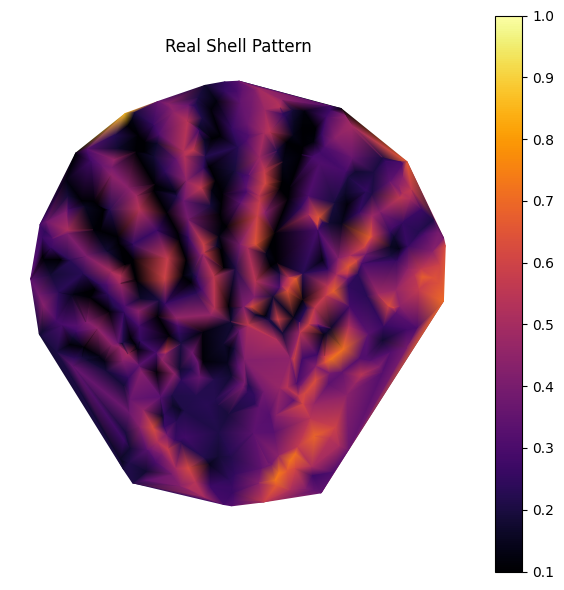

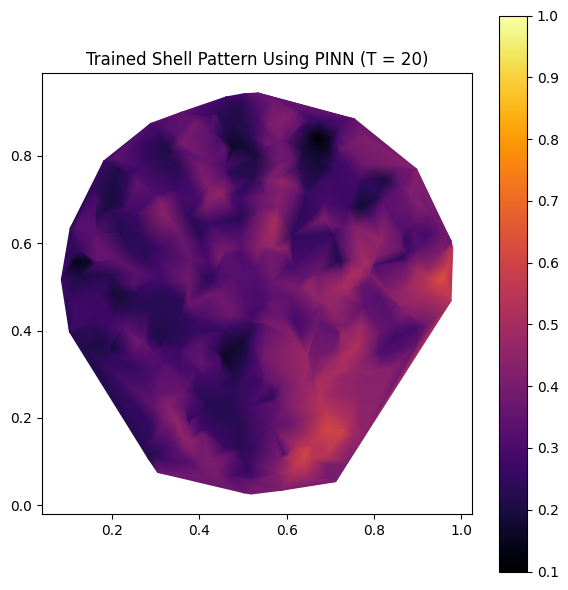

In [32]:
vmin = 0.1   # or min(min(real_pattern), min(a))
vmax = 1.0   # or max(max(real_pattern), max(a))

plt.figure(figsize=(6, 6))
plt.tripcolor(triang, real_pattern, shading='gouraud', cmap='inferno', vmin=vmin, vmax=vmax)
plt.gca().set_aspect('equal')
plt.title("Real Shell Pattern")
plt.colorbar()
plt.axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
FigureCanvas(fig)
im = ax.tripcolor(triang, a, shading='gouraud', cmap='inferno', vmin=vmin, vmax=vmax)
ax.set_aspect('equal')
ax.set_title("Trained Shell Pattern Using PINN (T = 20)")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


In [33]:
final_params

{'Du': tensor(0.0016, grad_fn=<ExpBackward0>),
 'Dv': tensor(0.0002, grad_fn=<ExpBackward0>),
 'rho': tensor(0.0414, grad_fn=<ExpBackward0>),
 'kappa': tensor(2.1421, grad_fn=<ExpBackward0>),
 'rho0': tensor(0.1178, grad_fn=<ExpBackward0>),
 'mu2': tensor(1.6739e-06, grad_fn=<ExpBackward0>),
 'sigma': tensor(2.8301e-05, grad_fn=<ExpBackward0>),
 'eta': tensor(0.0005, grad_fn=<ExpBackward0>),
 'h0': 0.1}